In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [3]:
# Functions for CLAHE and LBP
def apply_clahe(image):
    """Apply CLAHE to a grayscale image."""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def apply_lbp(image, radius=1, n_points=8, method='uniform'):
    """Apply Local Binary Pattern (LBP) to an image."""
    lbp = local_binary_pattern(image, n_points, radius, method)
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())  # Normalize to [0, 1]
    return lbp.astype(np.float32)

In [5]:
# Custom Dataset Class with CLAHE and LBP
class QRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and convert to grayscale for CLAHE and LBP
        image = cv2.imread(image_path)
        if image is None:
            raise RuntimeError(f"Failed to load image: {image_path}")
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE
        clahe_image = apply_clahe(gray_image)

        # Apply LBP
        lbp_image = apply_lbp(clahe_image)

        # Stack CLAHE and LBP as channels and convert to 3-channel image
        stacked_image = np.stack([clahe_image / 255.0, lbp_image, lbp_image], axis=-1)  # Duplicate LBP channel
        stacked_image = Image.fromarray((stacked_image * 255).astype(np.uint8))  # Convert back to PIL

        # Apply torchvision transformations
        if self.transform:
            stacked_image = self.transform(stacked_image)

        return stacked_image, label

In [7]:
# Define Paths   
train_dir = r"C:\Users\J\Downloads\QRCode_Detection_Project\data\train"
test_dir = r"C:\Users\J\Downloads\QRCode_Detection_Project\data\test"

# Fetch all image paths and labels
def get_data(data_dir):
    image_paths, labels, label_mapping = [], [], {}
    label_counter = 0

    for label_name in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(label_dir): continue

        if label_name not in label_mapping:
            label_mapping[label_name] = label_counter
            label_counter += 1

        for file in os.listdir(label_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(label_dir, file))
                labels.append(label_mapping[label_name])
    
    return image_paths, labels, label_mapping

train_image_paths, train_labels, train_label_mapping = get_data(train_dir)
test_image_paths, test_labels, test_label_mapping = get_data(test_dir)

# Print the number of images in each directory
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of testing images: {len(test_image_paths)}")

Number of training images: 502
Number of testing images: 60


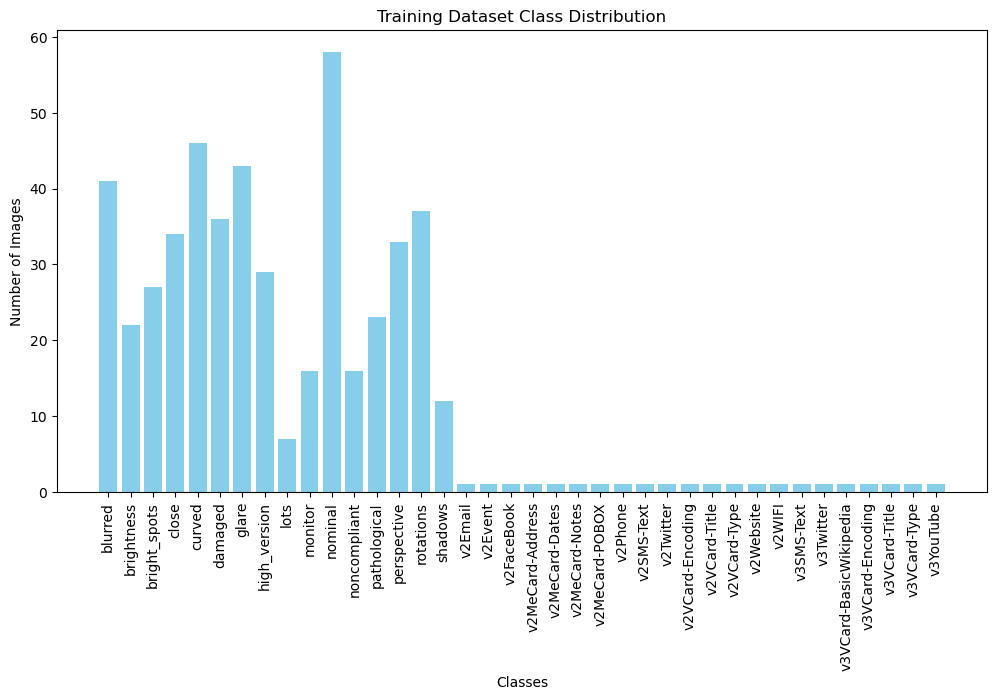

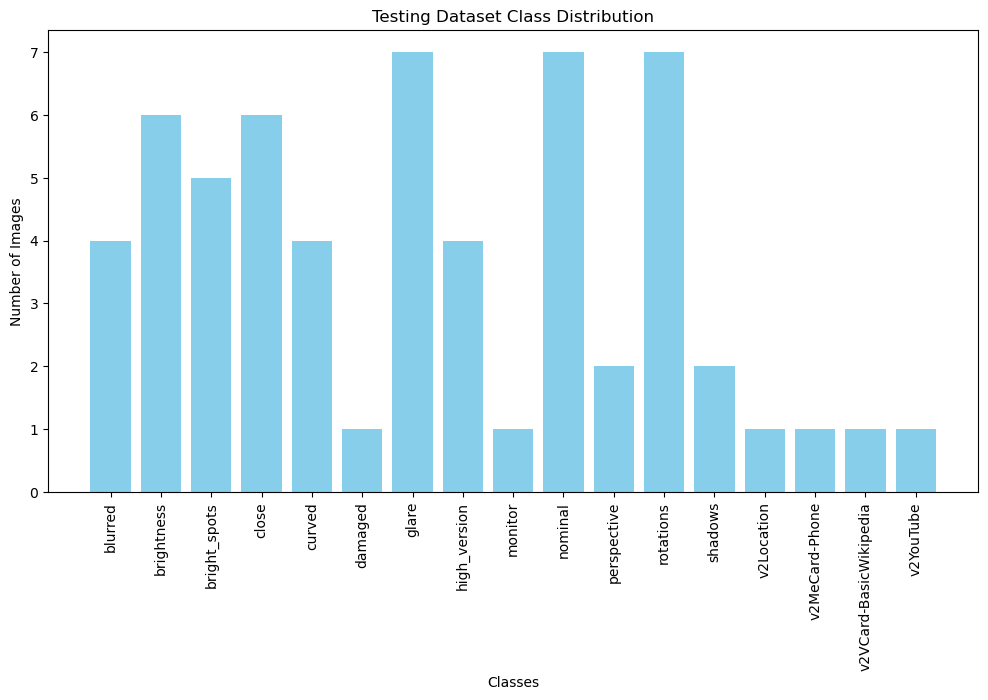

In [9]:
# Visualize the number of images in each class
def plot_class_distribution(labels, label_mapping, title):
    label_counts = {label: labels.count(idx) for label, idx in label_mapping.items()}
    labels, counts = zip(*label_counts.items())

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Plot the class distribution for training and testing datasets
plot_class_distribution(train_labels, train_label_mapping, 'Training Dataset Class Distribution')
plot_class_distribution(test_labels, test_label_mapping, 'Testing Dataset Class Distribution')

In [11]:
# Transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust for 3 channels
])

# Datasets and Loaders
train_dataset = QRDataset(train_image_paths, train_labels, transform=transform)
test_dataset = QRDataset(test_image_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [15]:
# Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained MobileNetV2 model with weights
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)  # Updated to use weights

num_classes = len(set(train_labels))

# Replace the classifier head of the model to match the number of classes in your dataset
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [17]:
# Training Loop
train_losses, train_accuracies = [], []

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        try:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue

    train_acc = 100. * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Epoch [{epoch+1}], Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Step the scheduler
    scheduler.step(train_loss)

Epoch 1/20: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch [1], Train Loss: 2.3964, Accuracy: 44.42%


Epoch 2/20: 100%|██████████| 16/16 [01:08<00:00,  4.31s/it]


Epoch [2], Train Loss: 1.8033, Accuracy: 63.94%


Epoch 3/20: 100%|██████████| 16/16 [01:09<00:00,  4.32s/it]


Epoch [3], Train Loss: 1.5989, Accuracy: 68.13%


Epoch 4/20: 100%|██████████| 16/16 [01:10<00:00,  4.42s/it]


Epoch [4], Train Loss: 1.4108, Accuracy: 74.90%


Epoch 5/20: 100%|██████████| 16/16 [01:08<00:00,  4.30s/it]


Epoch [5], Train Loss: 1.2975, Accuracy: 80.88%


Epoch 6/20: 100%|██████████| 16/16 [01:08<00:00,  4.27s/it]


Epoch [6], Train Loss: 1.3374, Accuracy: 78.88%


Epoch 7/20: 100%|██████████| 16/16 [01:08<00:00,  4.28s/it]


Epoch [7], Train Loss: 1.1966, Accuracy: 83.27%


Epoch 8/20: 100%|██████████| 16/16 [01:08<00:00,  4.25s/it]


Epoch [8], Train Loss: 1.1867, Accuracy: 83.07%


Epoch 9/20: 100%|██████████| 16/16 [01:09<00:00,  4.32s/it]


Epoch [9], Train Loss: 1.0995, Accuracy: 87.65%


Epoch 10/20: 100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


Epoch [10], Train Loss: 1.1066, Accuracy: 85.66%


Epoch 11/20: 100%|██████████| 16/16 [01:08<00:00,  4.28s/it]


Epoch [11], Train Loss: 1.0915, Accuracy: 86.85%


Epoch 12/20: 100%|██████████| 16/16 [01:08<00:00,  4.28s/it]


Epoch [12], Train Loss: 1.0668, Accuracy: 87.85%


Epoch 13/20: 100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


Epoch [13], Train Loss: 1.0091, Accuracy: 90.64%


Epoch 14/20: 100%|██████████| 16/16 [01:08<00:00,  4.30s/it]


Epoch [14], Train Loss: 0.9951, Accuracy: 91.24%


Epoch 15/20: 100%|██████████| 16/16 [01:08<00:00,  4.27s/it]


Epoch [15], Train Loss: 0.9711, Accuracy: 92.23%


Epoch 16/20: 100%|██████████| 16/16 [01:08<00:00,  4.30s/it]


Epoch [16], Train Loss: 1.0107, Accuracy: 90.64%


Epoch 17/20: 100%|██████████| 16/16 [01:08<00:00,  4.27s/it]


Epoch [17], Train Loss: 1.0146, Accuracy: 90.04%


Epoch 18/20: 100%|██████████| 16/16 [01:08<00:00,  4.30s/it]


Epoch [18], Train Loss: 0.9468, Accuracy: 92.03%


Epoch 19/20: 100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


Epoch [19], Train Loss: 0.9346, Accuracy: 92.43%


Epoch 20/20: 100%|██████████| 16/16 [01:10<00:00,  4.40s/it]

Epoch [20], Train Loss: 0.8980, Accuracy: 93.43%


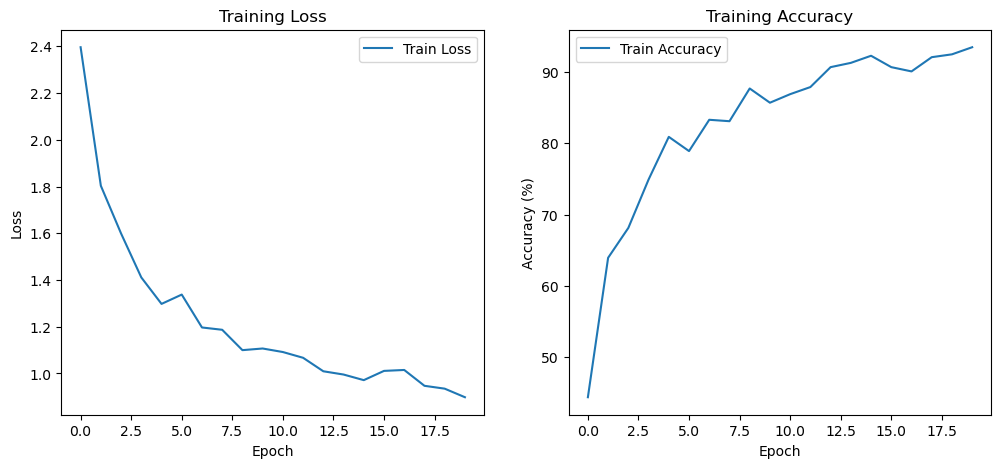

In [19]:
# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.show()

In [21]:
# Final Test Evaluation at the End of Training
model.eval()  # Set the model to evaluation mode
correct, total = 0, 0
test_loss = 0.0

print("Evaluating the final model on the test set...")
with torch.no_grad():  # Disable gradient calculation
    for images, labels in tqdm(test_loader, desc="Testing"):
        try:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue

# Calculate final test metrics
test_loss /= len(test_loader)
test_acc = 100. * correct / total

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Correct Predictions: {correct}, Total Samples: {total}")

print("Training Complete.")

# Print the learning rate
print(f"Learning Rate: {scheduler.get_last_lr()}")

Evaluating the final model on the test set...


Testing: 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

Final Test Loss: 3.3430
Final Test Accuracy: 50.00%
Correct Predictions: 30, Total Samples: 60
Training Complete.
Learning Rate: [0.001]


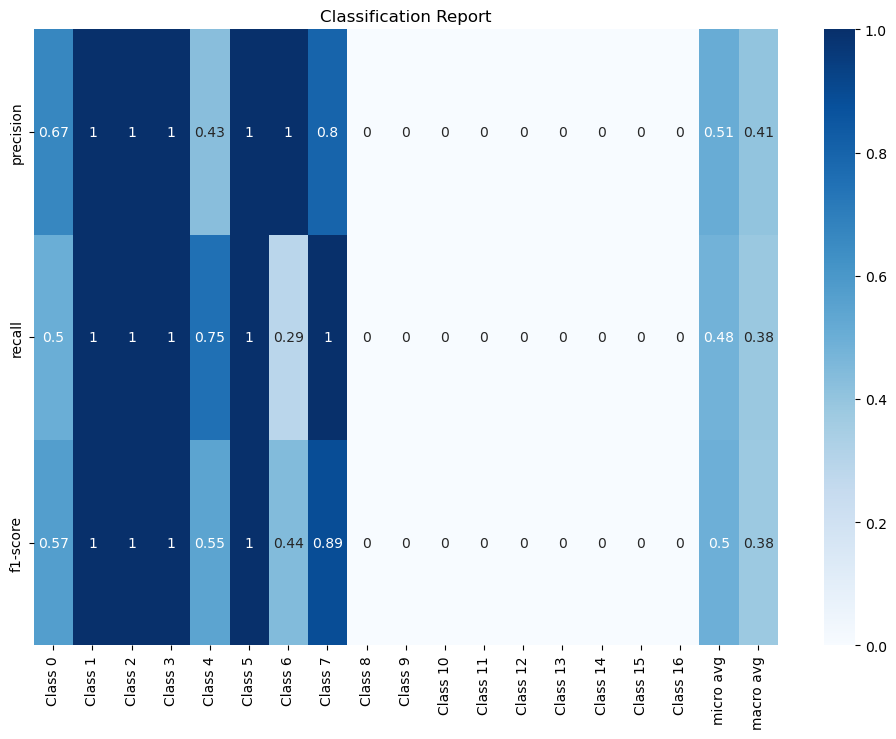

In [29]:

# Plot Test Results
# Collect true and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate unique labels and class names based on the test set
unique_labels = sorted(set(y_true))
class_names = [f'Class {i}' for i in unique_labels]

# Generate classification report
report = classification_report(y_true, y_pred, labels=unique_labels, target_names=class_names, output_dict=True, zero_division=0)

# Convert the classification report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()